# Generalized Linear Models with PyMC3

> Salvatier J, Wiecki TV, Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55

Generalized Linear Models (GLMs) are a class of flexible models that are widely used to estimate regression relationships between a single outcome variable and one or multiple predictors. Because these models are so common, PyMC3 offers a glm submodule that allows flexible creation of various GLMs with an intuitive R-like syntax.

## first example - data from "linear model"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma


# Convert X and Y to a pandas DataFrame
import pandas

df = pandas.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

## Model specification

In [6]:
import pymc3 as pm
from pymc3.glm import glm

with pm.Model() as model_glm:
    glm('y ~ x1 + x2', df)
    trace = pm.sample(5000)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -190.01: 100%|██████████| 200000/200000 [00:33<00:00, 5901.58it/s]
Finished [100%]: Average ELBO = -190.05
100%|██████████| 5000/5000 [00:11<00:00, 421.38it/s]


The error distribution, if not specified via the family argument, is assumed to be normal. In the case of logistic regression, this can be modified by passing in a Binomial family object.

In [8]:
from pymc3.glm.families import Binomial

# convert to binary outcome
df_logistic = pandas.DataFrame({'x1': X1, 'y': Y > np.median(Y)})

# define logistic regression model
with pm.Model() as model_glm_logistic:
    glm('y ~ x1', df_logistic, family=Binomial())

/home/floe/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


## second example - new data

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

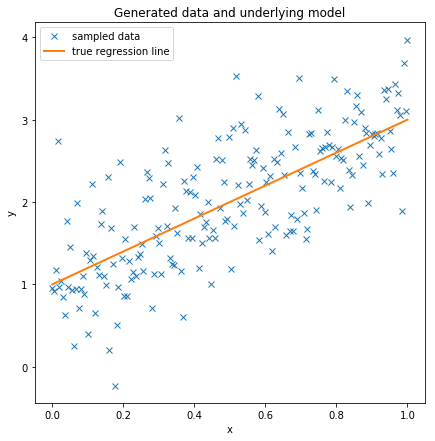

In [12]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

## Build model: manual

In [14]:
with pm.Model() as model_glm: 
    
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)

    # Inference
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, start=start, progressbar=False) # draw 2000 posterior samples using NUTS sampling

Optimization terminated successfully.
         Current function value: 168.278364
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20


## Build model: the easy way
* shortcut provided by PyMC3
* shorter code
* exactly the same procedure as above
* still customizable

In [16]:
with pm.Model() as model_glm2:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.glm('y ~ x', data)
    
    # Inference
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, progressbar=False) # draw 2000 posterior samples using NUTS sampling

Optimization terminated successfully.
         Current function value: 189.911410
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20


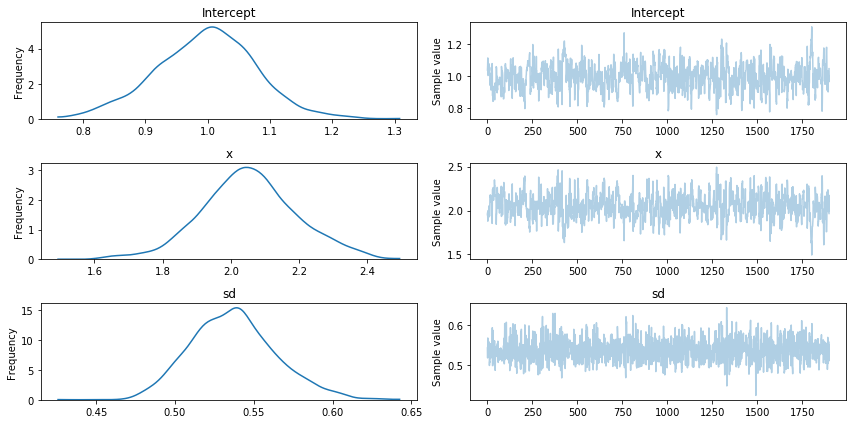

In [18]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

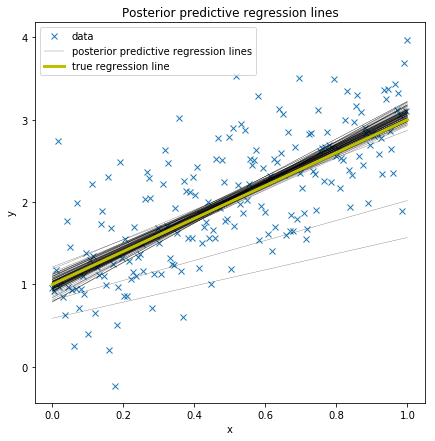

In [21]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.glm.plot_posterior_predictive(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');